# Import

In [14]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo_oad_training.unit import convert_from



configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [15]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [16]:
update_default_inputs(disciplines, {"slst": 101870.41502677, "n_pax":120, "area":114.5555049, "ar":13.73377554})
disciplines[0].io.input_grammar.defaults

{'area': 114.5555049, 'ar': 13.73377554, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [17]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

# Import surrogate model

In [18]:
surrogate_disciplines = from_pickle("my_surrogate_2.pkl")
surrogate_disciplines

Surrogate discipline: PolyReg_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: PolynomialRegressor
   Inputs: aef, cef, sef
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create sample dataset


In [19]:
surrogate_dataset = sample_disciplines([surrogate_disciplines], uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=5000)

 WARNING - 10:34:11: No coupling in MDA, switching chain_linearize to True.
    INFO - 10:34:11: *** Start Sampling execution ***
    INFO - 10:34:11: Sampling
    INFO - 10:34:11:    Disciplines: PolyReg_Sampling
    INFO - 10:34:11:    MDO formulation: MDF
    INFO - 10:34:11: Running the algorithm OT_MONTE_CARLO:
    INFO - 10:34:29:    100%|██████████| 5000/5000 [00:18<00:00, 275.76 it/sec]
    INFO - 10:34:29: *** End Sampling execution (time: 0:00:18.228270) ***


# Check stat

In [20]:
statistics = EmpiricalStatistics(surrogate_dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

{'aef': array([1.00658106]), 'cef': array([1.00665289]), 'fm': array([0.56286663]), 'length': array([32.]), 'mtom': array([63828.79743473]), 'sef': array([1.00684398]), 'span': array([39.66458863]), 'tofl': array([1821.40488204]), 'vapp': array([65.19190647]), 'vz': array([4.78557439])}
{'aef': array([0.00848757]), 'cef': array([0.00848433]), 'fm': array([0.01350419]), 'length': array([0.]), 'mtom': array([304.63969779]), 'sef': array([0.00850743]), 'span': array([7.10542736e-15]), 'tofl': array([16.46897815]), 'vapp': array([0.17042969]), 'vz': array([0.09623895])}


# Propagate uncertainties

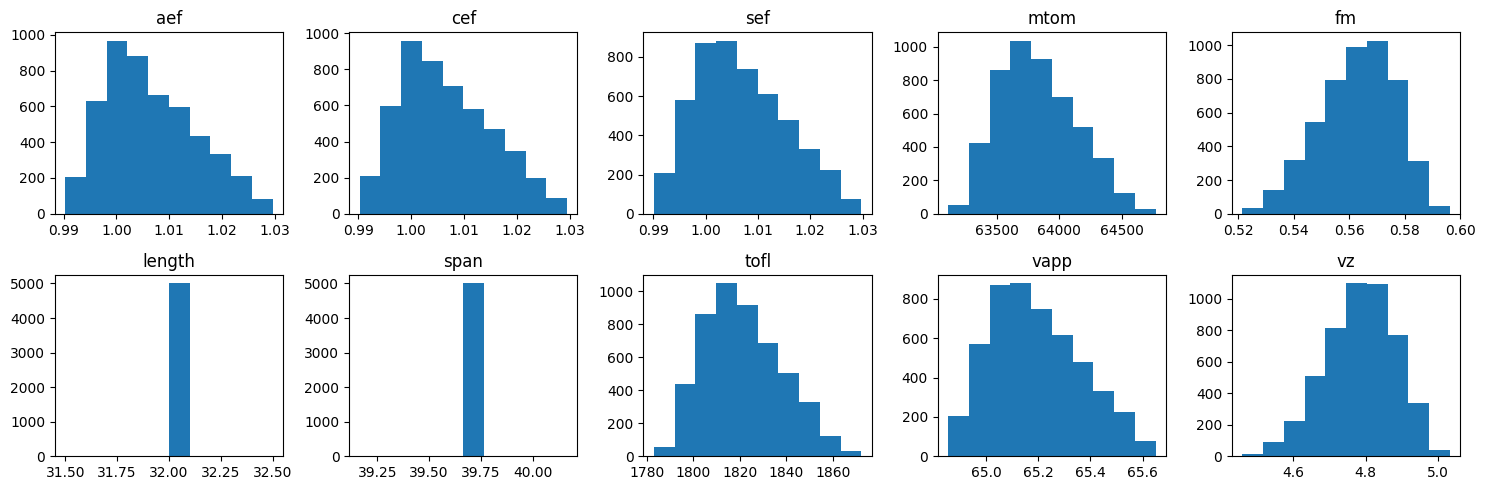

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

axes = axes.ravel()

for ax, name in zip(axes, ["aef", "cef", "sef", "mtom", "fm", "length", "span", "tofl", "vapp", "vz"]):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data)
    ax.set_title(name)

plt.tight_layout()
plt.show()

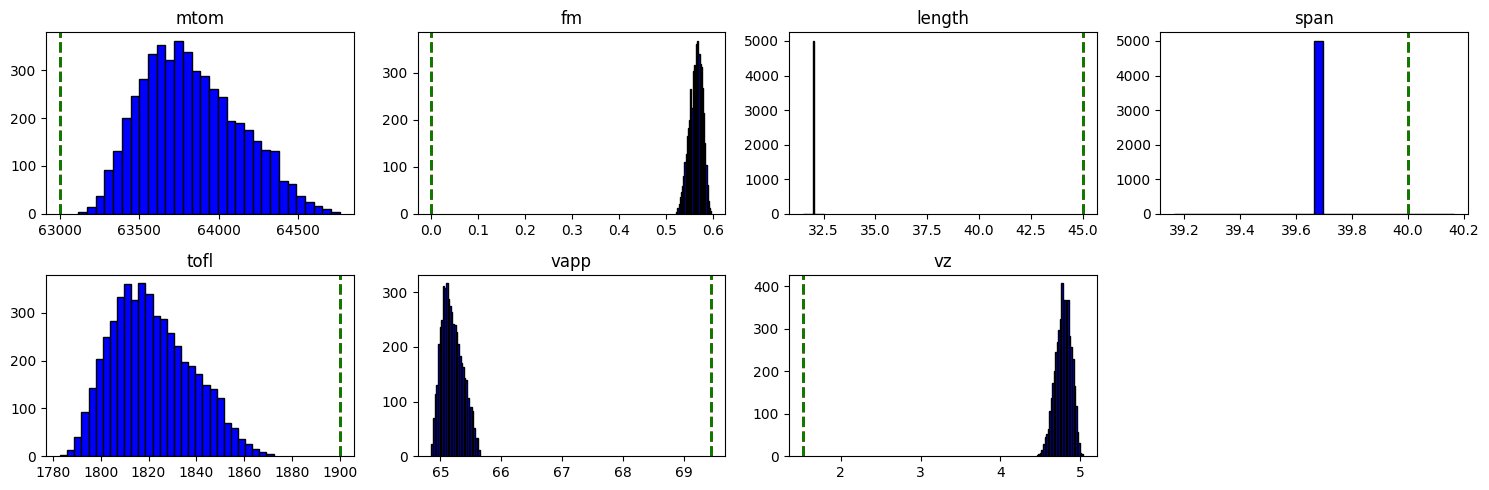

In [22]:
variable_names = ["mtom", "fm", "length", "span", "tofl", "vapp", "vz"]

constraints = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 
optimum_values = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()

for ax, name, cons_val, opt_val in zip(axes, variable_names, constraints, optimum_values):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='blue', edgecolor='black')
    ax.axvline(cons_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(opt_val, color='green', linestyle='--', linewidth=2)

    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


# Sobol analysis

In [23]:
sobol = SobolAnalysis()
samples = sobol.compute_samples([surrogate_disciplines], uncertain_space, 10000)
# to_pickle(samples, "samples.pkl")
sobol = SobolAnalysis(samples)
sobol.compute_indices(output_names=["mtom"])

 WARNING - 10:34:30: No coupling in MDA, switching chain_linearize to True.
    INFO - 10:34:30: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 10:34:30: SobolAnalysisSamplingPhase
    INFO - 10:34:30:    Disciplines: PolyReg_Sampling
    INFO - 10:34:30:    MDO formulation: MDF
    INFO - 10:34:30: Running the algorithm OT_SOBOL_INDICES:
    INFO - 10:35:04:    100%|██████████| 10000/10000 [00:33<00:00, 294.87 it/sec]
    INFO - 10:35:04: *** End SobolAnalysisSamplingPhase execution (time: 0:00:34.045338) ***


SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.05645883]), 'cef': array([0.13794479]), 'sef': array([0.83391537])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07722343]]), 'sef': array([[-0.06926002]])}, 'cef': {'aef': array([[-0.07722343]]), 'cef': array([[0.]]), 'sef': array([[-0.10624836]])}, 'sef': {'aef': array([[-0.06926002]]), 'cef': array([[-0.10624836]]), 'sef': array([[0.]])}}]}, total={'mtom': [{'aef': array([0.01739545]), 'cef': array([0.09213327]), 'sef': array([0.85134531])}]})

In [24]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'mtom': [{'aef': array([0.05645883]),
           'cef': array([0.13794479]),
           'sef': array([0.83391537])}]}
{'mtom': [{'aef': array([0.01739545]),
           'cef': array([0.09213327]),
           'sef': array([0.85134531])}]}


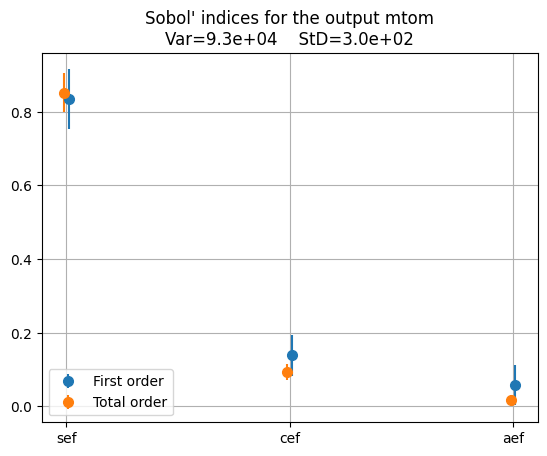

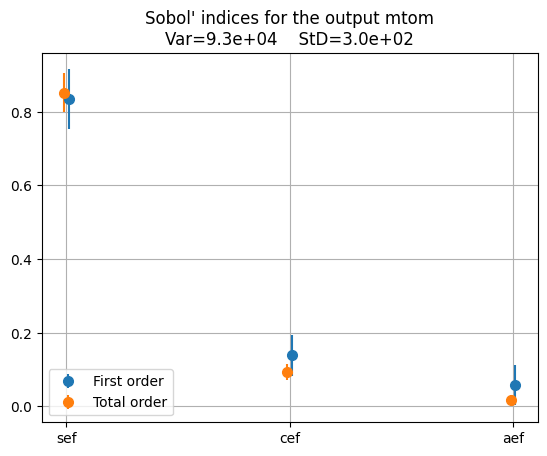

In [25]:
sobol.plot("mtom", save=False, show=False)